In [2]:
import torch
import torch.nn as nn
from score_models import VESDE, VPSDE, ScoreModel, EnergyModel, SDE
from score_models.base import ScoreModelBase
import matplotlib.pyplot as plt
import numpy as np


In [12]:
class GaussianEnergyModel(nn.Module):
    def __init__(self, sde, mean, std):
        super().__init__()
        self.sde = sde
        self.mean = mean
        self.std = std
        self.hyperparameters = {"nn_is_energy": True}

    def forward(self, t, x):
        mu, sigma = self.sde.marginal_prob_scalars(t)
        # print(mu[0], sigma[0])
        r = x - mu * self.mean
        variance = mu**2 * self.std**2 + sigma**2
        ret = torch.sum(r**2 / variance, dim=1, keepdims=True) / 2
        return ret * sigma

In [14]:
# Let's do VE first, see if we get stuff working as expected
sigma_min = 1e-3
sigma_max = 50
sde = VESDE(sigma_min, sigma_max)

mean = 6
std = 1.
def true_density(x):
    return torch.exp(-0.5 * (x - mean)**2 / std**2) / std / np.sqrt(2 * np.pi)

net = GaussianEnergyModel(sde, mean, std)
score = EnergyModel(net, sigma_min=sigma_min, sigma_max=sigma_max, nn_is_energy=True)

N = 10000
samples = score.sample(shape=[N, 1], steps=100)

Using the Variance Exploding SDE


Sampling from the prior | t = 0.0 | sigma = 1.1e-03| scale ~ 1.0e+00: 100%|██████████| 100/100 [00:00<00:00, 364.50it/s]


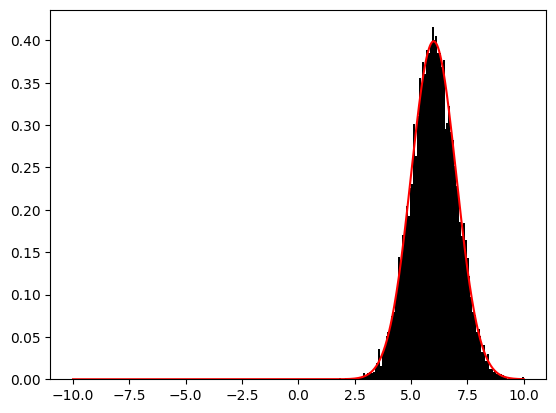

In [16]:
plt.hist(samples.squeeze(), bins=100, density=True, color="k")

x = torch.linspace(-10, 10, 1000)
plt.plot(x, true_density(x).detach().numpy(), color="r")

In [17]:
# Let's do VE first, see if we get stuff working as expected
beta_min = 1e-2
beta_max = 100
sde = VPSDE(beta_min, beta_max)

mean = 0.
std = 0.5
def true_density(x):
    return torch.exp(-0.5 * (x - mean)**2 / std**2) / std / np.sqrt(2 * np.pi)

net = GaussianEnergyModel(sde, mean, std)
score = EnergyModel(net, beta_min=beta_min, beta_max=beta_max, nn_is_energy=True)

N = 10000
samples = score.sample(shape=[N, 1], steps=1000)

Using the Variance Preserving SDE


Sampling from the prior | t = 0.0 | sigma = 7.8e-03| scale ~ 5.0e-01: 100%|██████████| 1000/1000 [00:02<00:00, 388.91it/s]


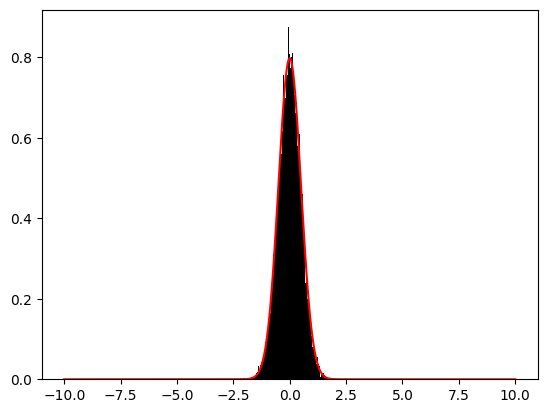

In [18]:
plt.hist(samples.squeeze(), bins=100, density=True, color="k")

x = torch.linspace(-10, 10, 1000)
plt.plot(x, true_density(x).detach().numpy(), color="r")